In [1]:
import celmech as cm
import rebound as rb
import numpy as np
from matplotlib import pyplot as plt
import sympy as sp

In [2]:
# Generate a simulation of equal mass, evenly spaced planets.
def get_sim(m,Npl,pratio,exfrac):
    alpha = pratio**(-2/3)
    ex = np.min((1/alpha-1,1-alpha)) # orbit-crossing eccentricity
    ecc = exfrac * ex
    sim = rb.Simulation()
    sim.add(m=1)
    P = 1
    for i in range(Npl):
        sim.add(m=m,P=P,l=np.random.uniform(-np.pi,np.pi),e=ecc,pomega= np.random.uniform(-np.pi,np.pi))
        P*= pratio
    sim.move_to_com()
    return sim

In [3]:

sim = get_sim(1e-5,5,1.15354,0.2) # system of five planets

pvars = cm.Poincare.from_Simulation(sim)
pham = cm.PoincareHamiltonian(pvars)
Hkep = pham.H.copy()

pham_inits = pham.state.values

jlo,jhi = np.floor(1 + 1/(1.3456-1)),np.ceil(1 + 1/(1.3456-1))
jlo,jhi = int(jlo),int(jhi)

In [4]:
#... for some reason I'm getting a warnings 
# when I try to do this in a loop...

pham.add_MMR_terms(jlo,1,max_order=2,indexIn=1,indexOut=2,inclinations=False)
pham.add_MMR_terms(jlo,1,max_order=2,indexIn=2,indexOut=3,inclinations=False)
pham.add_MMR_terms(jlo,1,max_order=2,indexIn=3,indexOut=4,inclinations=False)
pham.add_MMR_terms(jlo,1,max_order=2,indexIn=4,indexOut=5,inclinations=False)

pham.add_MMR_terms(jhi,1,max_order=2,indexIn=1,indexOut=2,inclinations=False)
pham.add_MMR_terms(jhi,1,max_order=2,indexIn=2,indexOut=3,inclinations=False)
pham.add_MMR_terms(jhi,1,max_order=2,indexIn=3,indexOut=4,inclinations=False)
pham.add_MMR_terms(jhi,1,max_order=2,indexIn=4,indexOut=5,inclinations=False)

pham.add_MMR_terms(jlo+jhi,2,max_order=2,indexIn=1,indexOut=2,inclinations=False)
pham.add_MMR_terms(jlo+jhi,2,max_order=2,indexIn=2,indexOut=3,inclinations=False)
pham.add_MMR_terms(jlo+jhi,2,max_order=2,indexIn=3,indexOut=4,inclinations=False)
pham.add_MMR_terms(jlo+jhi,2,max_order=2,indexIn=4,indexOut=5,inclinations=False)



# print("Adding terms for the {}:{}, {}:{}, and {}:{} MMRs".format(jlo,jlo-1,jhi,jhi-1,jlo+jhi,jlo+jhi-2))


# for i in range(1,pvars.N-1):
#     pham.add_MMR_terms(jlo,1,max_order=2,indexIn=i,indexOut=i+1,inclinations=False)
#     pham.add_MMR_terms(jhi,1,max_order=2,indexIn=i,indexOut=i+1,inclinations=False)
#     pham.add_MMR_terms(jhi+jhi,2,max_order=2,indexIn=i,indexOut=i+1,inclinations=False)
    

In [5]:
from celmech.canonical_transformations import reduce_hamiltonian

In [6]:
# Reduce to eliminate dependence on inclination variables...
Hpert = reduce_hamiltonian(pham)
# ...and subrtract Keplerian piece to create a Hamiltonian that is just the perturbation terms
Hpert.H += -1 * Hkep

In [7]:
Npl = 5

jac=Hpert.calculate_jacobian()

# indicies of lambda,Lambda, and x variables
l_indx = [2*j for j in range(Npl)]
L_indx = [2*Npl + 2*j for j in range(Npl)]
evar_indx = [1 + 2*j for j in range(Npl)] + [2*Npl+ 1 + 2*j for j in range(Npl)]

# Atilde matrix
Atilde = np.array([[jac[i,j] for j in evar_indx] for i in evar_indx])

# variable symbols
evarsymbols = [Hpert.qp_vars[j] for j in evar_indx]
L_symbols = [Hpert.qp_vars[j] for j in L_indx]
l_symbols = [Hpert.qp_vars[j] for j in l_indx]

# set ecc variables to zero to get btilde vector
ezero_rule={s:0 for s in evarsymbols}
btilde = np.array([Hpert.N_flow[i].xreplace(ezero_rule).subs(Hpert.qp) for i in evar_indx],dtype = float)

# Initial values
x0 = np.array([Hpert.state.values[i] for i in evar_indx])
l0 = np.array([Hpert.state.values[i] for i in l_indx])
L0 = np.array([Hpert.state.values[i] for i in L_indx])

In [8]:
from celmech.miscellaneous import getOmegaMatrix
# Omega matrix
OmegaN = getOmegaMatrix(5)

In [9]:
# get A as a function of lambdas
Amtrx = sp.Matrix(2*Npl,2*Npl,lambda i,j: sp.diff(Hpert.N_H,evarsymbols[i],evarsymbols[j]))
Afn = sp.lambdify(l_symbols,Amtrx)

# Get b as a function of lambdas
bvec = sp.Matrix([sp.diff(Hpert.N_H,evar).xreplace(ezero_rule) for evar in evarsymbols])
bfn = sp.lambdify(l_symbols,bvec)

# Derivatives of A and b as a function of lambda
grad_A = []
grad_b = sp.Matrix(Npl,2*Npl,lambda i,j: sp.diff(bvec[j],l_symbols[i]))
for l_symbol in l_symbols:
    grad_A.append(sp.diff(Amtrx,l_symbol))
grad_Afn = sp.lambdify(l_symbols,grad_A)
grad_bfn = sp.lambdify(l_symbols,grad_b)

In [10]:
GMmvec = pvars.G * pvars.G * np.array([p.M**2 * p.mu**3 for p in pvars.particles[1:]])

# Test 'H1soln'
Compare the analytic solution derived using `H1soln` to direct integration of equations of motion generated by `Hpert`

In [11]:
import sys
sys.path.append("../code/")
from DisturbingFunctionSplittingMethod import H0soln,H1soln

In [12]:
Nout = 100
Tfin=250
state0  = np.array(Hpert.state.values)
states = np.zeros((Nout,state0.shape[0]))
times = np.linspace(0,Tfin,Nout)

xsoln = np.zeros((Nout,x0.shape[0]))
Lsoln = np.zeros((Nout,L0.shape[0]))
lsoln = np.zeros((Nout,L0.shape[0]))
for i,t in enumerate(times):
    Hpert.integrate(t)
    states[i] = Hpert.state.values
    xsoln[i],lsoln[i],Lsoln[i] = H1soln(x0,l0,L0,t,Afn,bfn,grad_Afn,grad_bfn,getOmegaMatrix(5),5)
    

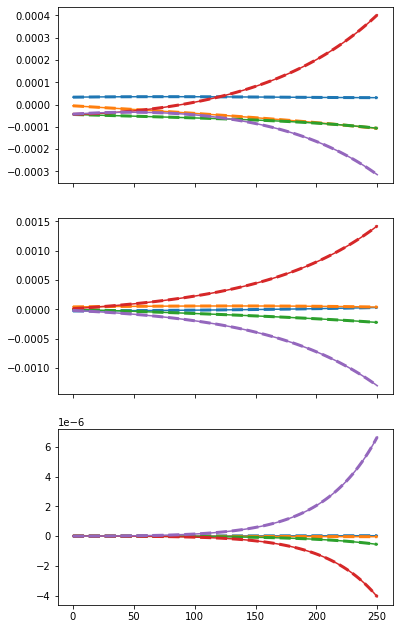

In [13]:
fig,ax = plt.subplots(3,1,sharex=True,figsize=(6,11))

# Plot etas
plt.sca(ax[0])
for i in range(5):
    l,=plt.plot(times,states[:,1+2*i])
    plt.plot(times,xsoln[:,i],color=l.get_color(),ls='--',lw=3)

# Plot kappas
plt.sca(ax[1])
for i in range(5):
    l,=plt.plot(times,states[:,2*5+1+2*i])
    plt.plot(times,xsoln[:,5+i],color=l.get_color(),ls='--',lw=3)

# Plot Lambdas
plt.sca(ax[2])
for i in range(5):
    l,=plt.plot(times,states[:,2*5+2*i]-states[0,2*5+2*i])
    plt.plot(times,Lsoln[:,i]-Lsoln[0,i],ls='--',lw=3,color=l.get_color())

# Integrate equations of motion using splitting scheme.

In [14]:
compare_test = True # compare to direct integration with celmech?

In [15]:
to_state = lambda x,l,L: np.array([(l[i],x[i],0) for i in range(5)] + [(L[i],x[5+i],0) for i in range(5)]).reshape(-1)

In [16]:
h = 0.25 # time step
Niter = 100 # number of iterations

# Solution arrays
xsoln = np.zeros((Niter,x0.shape[0]))
Lsoln = np.zeros((Niter,L0.shape[0]))
lsoln = np.zeros((Niter,l0.shape[0]))
Energy = np.zeros(Niter)

if compare_test:
    states = np.zeros((Niter,pham.N_dim))
    pham.state.values  = pham_inits
    pham.state.t = 0

# initial values
x,l,L = x0.copy(),l0.copy(),L0.copy()

# main loop
for i in range(Niter):
    xsoln[i],lsoln[i],Lsoln[i] = x,l,L
    Energy[i] = pham.H_func(*to_state(x,l,L))
    x,l,L = H0soln(x,l,L,0.5*h,GMmvec)
    x,l,L = H1soln(x,l,L,h,Afn,bfn,grad_Afn,grad_bfn,getOmegaMatrix(5),5)
    x,l,L = H0soln(x,l,L,0.5*h,GMmvec)
    
    if compare_test:
        pham.integrate(i*h)
        states[i] = pham.state.values 

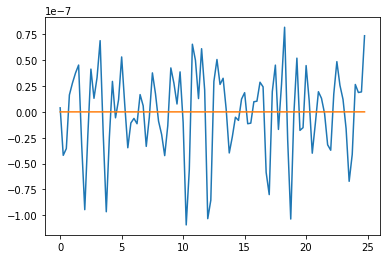

In [17]:
# Plot Energy
Eav = np.mean(Energy)
times = h*np.arange(Niter)
plt.plot(times,Energy/Eav - 1)
if compare_test:
    Epham = pham.H_func(*states.T)
    Eav_pham = np.mean(Epham)
    plt.plot(times,Epham/Eav_pham - 1)

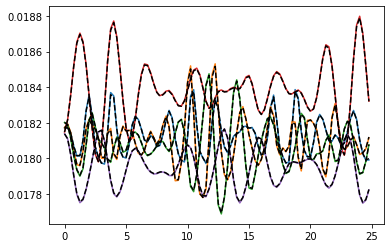

In [18]:
# Plot eccentricities 
for i in range(5):
    ecc = np.sqrt((xsoln[:,i]**2 + xsoln[:,i+5]**2)/Lsoln[:,i])
    l, = plt.plot(times, ecc ,zorder = 0)
    if compare_test:
        esq  = (states[:,3*i+1]**2 + states[:,pham.N_dof + 3*(i)+1]**2) / states[:,3*i+pham.N_dof]
        plt.plot(times,np.sqrt(esq),ls='--',color='k',zorder=99)

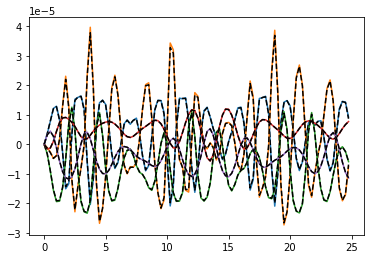

In [19]:
# Plot Lambdas
for i in range(5):
    plt.plot(np.arange(Niter) * h, (Lsoln[:,i] - Lsoln[0,i]) / Lsoln[0,i])
    if compare_test:
        ipham = pham.qp_vars.index(L_symbols[i])
        plt.plot(np.arange(Niter) * h, (states[:,ipham]-states[0,ipham])/states[0,ipham],ls='--',color='k')

# Eccentricity convergence test

In [21]:
Nsteps = 2**np.arange(0,7)
T = 1
eta = np.zeros(len(Nsteps))
delta_eta = np.zeros(len(Nsteps))

for k,Nstep in enumerate(Nsteps):
    pham.state.t = 0
    pham.state.values = pham_inits
    pham.integrate(T)
    x,l,L = x0.copy(),l0.copy(),L0.copy()
    h = T / Nstep
    for i in range(Nstep):
        x,l,L = H0soln(x,l,L,0.5*h,GMmvec)
        x,l,L = H1soln(x,l,L,h,Afn,bfn,grad_Afn,grad_bfn,getOmegaMatrix(5),5)
        x,l,L = H0soln(x,l,L,0.5*h,GMmvec)
    delta_eta[k] = (pham.state.values[1] - x[0])/pham.state.values[1]
    eta[k] = x[0]

In [22]:
hvals = T / Nsteps

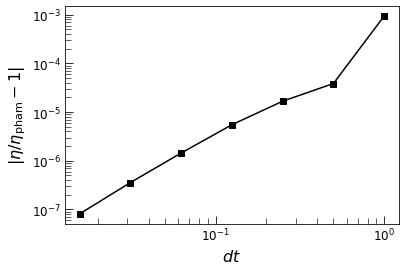

In [23]:
plt.plot(hvals,np.abs(delta_eta),'ks-')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$|\eta/\eta_\mathrm{pham}-1|$",fontsize=16)
plt.xlabel(r"$dt$",fontsize=16)
plt.tick_params(labelsize=12,direction='in',size=8)
plt.tick_params(which='minor',direction='in',size=6)

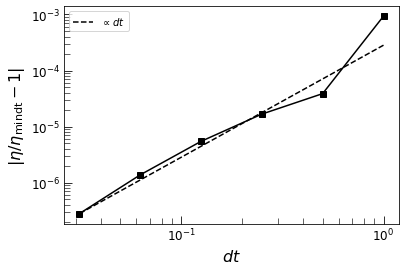

In [24]:
frac_err=np.abs(eta/eta[-1]-1)[:-1]
plt.plot(hvals[:-1],frac_err,'ks-')
plt.plot(hvals[:-1],frac_err[-1] * (hvals[:-1]/hvals[-2])**2 ,'k--',label=r"$\propto dt $")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylabel(r"$|\eta/\eta_\mathrm{min dt}-1|$",fontsize=16)
plt.xlabel(r"$dt$",fontsize=16)
plt.tick_params(labelsize=12,direction='in',size=8)
plt.tick_params(which='minor',direction='in',size=6)